# 05 Hittable object

* 장면에 두 개의 구를 배치하고 ray가 어느 구와 먼저 만나는지 확인합니다.

In [14]:
from __future__ import annotations
from typing import List
import sys

import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

infinity = sys.float_info.max

In [15]:
def normalize(vec: np.array, eps: float = 1e-6):
    return vec / (LA.norm(vec) + eps)


def blend(color1: np.array, color2: np.array, t: float):
    return (1.0 - t) * color1 + t * color2

In [16]:
class Ray:
    def __init__(self, origin: np.array, direction: np.array) -> None:
        self.origin: np.array = origin
        self.direction: np.array = normalize(direction)

    def at(self, t: float) -> np.array:
        return self.origin + t * self.direction

### Hittable과 HitRecord
두 개 이상의 구가 장면에 있는 상황을 위해 Hittable과 HitRecord 클래스를 정의합니다.
* Hittable
    * Hittable은 미구현된 hit 함수를 갖는 인터페이스 클래스입니다.
    * 장면에 배치하는 물체들은 Hittable을 상속받아 hit 함수를 정의해야 합니다.
    * hit 함수는 ray와 ray가 진행 가능한 범위인 t_min, t_max를 입력으로 받아 두 가지를 확인합니다.
        * ray가 물체와 만나는지 확인합니다.
        * ray가 물체와 만난다면 만나는 지점이 t_min, t_max의 중간에 있는지 확인합니다.
        * 위의 조건이 통과하면 HitRecord를 생성해 반환합니다.
* HitRecord
    * Ray가 물체와 만난 지점의 위치와 해당 위치의 법선 벡터, 그리고 ray가 진행한 거리 t를 저장합니다.

### 도형 표면의 법선 벡터

<center>
<img src="./images/normal_sides.png" width="400px" title="normal_sides"/>
</center>

* ray는 도형의 바깥쪽이나 안쪽에서 도형의 표면과 만날 수 있습니다.    
* 물체의 재질에 따라서 도형 바깥쪽 또는 안쪽으로 향하는 법선 벡터를 필요로 합니다.
    * 투명한 구슬 또는 양면이 인쇄된 종이
* 여기서는 표면의 법선 벡터가 ray 가 온 방향으로 향하도록 계산합니다.
    * 기본적으로 도형은 도형의 바깥쪽으로 향하는 법선 벡터을 가지고 있습니다.
    * ray와 표면 법선 벡터의 내적 값이 + 면 도형 바깥쪽에 만난 상황으로 도형이 가지고 있는 법선 벡터를 반환합니다. 
    * ray와 표면 법선 벡터의 내적 값이 - 면 도형 안쪽에 만난 상황으로 도형이 가지고 있는 법선 벡터를 뒤집어서 반환합니다. 

### 두 방향 벡터의 내적

<center>
<img src="./images/directions.png" width="300px" title="directions"/>
</center>

* 두 방향 벡터의 내적 값은 방향에 따라 부호가 결정됩니다.
    * 위 그림의 모든 벡터는 단위 벡터라고 가정합니다.
    * dot(a, a) = +1.0 # 두 벡터의 방향이 같은 경우
    * dot(a, b) = +
    * dot(a, c) = 0.0 # 두 벡터가 서로 직교하는 같은 경우
    * dot(a, d) = -
    * dot(a, e) = -1.0 # 두 벡터의 방향이 서로 반대인 경우


In [17]:
class HitRecord:
    def __init__(self, point: np.array, normal: np.array, t: float) -> None:
        self.point = point
        self.normal = normal
        self.t = t

    def set_face_normal(self, ray: Ray, outward_normal: np.array) -> None:
        # if the ray hits the inside of the shape, it flips the outward normal.
        is_front_face = np.dot(ray.direction, outward_normal) < 0
        self.normal = outward_normal if is_front_face else -outward_normal

In [18]:
class Hittable:
    def hit(self, ray: Ray, t_min: float, t_max: float) -> HitRecord:
        raise NotImplementedError

In [19]:
class Sphere(Hittable):
    def __init__(self) -> None:
        self.center = np.zeros(3)
        self.radius = 1.0

    def __init__(self, center: np.array, radius: float) -> None:
        self.center = center
        self.radius = radius

    def hit(self, ray: Ray, t_min: float, t_max: float) -> HitRecord:
        dir_center_to_origin = ray.origin - self.center

        a = np.dot(ray.direction, ray.direction)
        half_b = np.dot(dir_center_to_origin, ray.direction)
        c = np.dot(dir_center_to_origin, dir_center_to_origin) - self.radius**2.0

        discriminant = half_b**2 - a * c
        if discriminant < 0:
            return None
        sqrt_d = np.sqrt(discriminant)

        # find the nearest root that lies in the acceptable range.
        t = (-half_b - sqrt_d) / a
        if t < t_min or t_max < t:
            t = (-half_b + sqrt_d) / a
            if t < t_min or t_max < t:
                return None

        point = ray.at(t)
        outward_normal = (point - self.center) / self.radius
        hit_record = HitRecord(point=point, normal=outward_normal, t=t)
        hit_record.set_face_normal(ray=ray, outward_normal=outward_normal)

        return hit_record

HittableList는 장면을 나타내는 클래스 입니다.
* Hittable들을 담을 수 있는 컨테이너 이면서 Hittable 클래스입니다.
    * 장면을 재귀적으로 구현합니다.
* hit 함수로 주어진 ray와 담고 있는 Hittable 물체들이 만나는지 확인 합니다.
* Ray가 물체와 부딪혔을 때의 t로 물체를 필터링해서 가장 가까운 시점에서 가장 가까운 물체의 HitRecord만 남깁니다.

### Hit 테스트 케이스
* Ray 시작점에서 가까운 물체를 먼저 테스트 하고 먼 물체를 나중에 테스트 하는 경우입니다.
    * Ray의 t_max가 가까운 물체와 만나는 지점으로 설정됩니다.
    * Ray의 t_max가 먼 물체와 만날 수 없는 거리로 설정되었기 때문에 먼 물체와의 테스트는 실패합니다.

<center>
<img src="./images/hit_1_1.png" width="300px" title="hit_case_1_1"/>
</center>
<center>
<img src="./images/hit_1_2.png" width="300px" title="hit_case_1_2"/>
</center>

* Ray 시작점에서 먼 물체를 먼저 테스트하고 가까운 물체를 나중에 테스트 하는 경우입니다.
    * Ray의 t_max가 먼 물체와 만나는 지점으로 설정됩니다.
    * Ray의 t_max가 층분히 먼 거리로 설정되었기 때문에 가까운 물체와의 테스트를 통과합니다.

<center>
<img src="./images/hit_2_1.png" width="300px" title="hit_case_2_1"/>
</center>
<center>
<img src="./images/hit_2_2.png" width="300px" title="hit_case_2_2"/>
</center>

In [20]:
class HittableList(Hittable):
    def __init__(self) -> None:
        self.objects: List[Hittable] = []

    def clear(self) -> None:
        self.objects.clear()

    def add(self, object: Hittable) -> None:
        self.objects.append(object)

    def hit(self, ray: Ray, t_min: float, t_max: float) -> HitRecord:
        record = None
        closest_so_far = t_max

        for object in self.objects:
            tmp_record = object.hit(ray=ray, t_min=t_min, t_max=closest_so_far)
            if tmp_record is not None:
                closest_so_far = tmp_record.t
                record = tmp_record

        return record

In [21]:
def ray_color(ray: Ray, world: Hittable) -> np.array:
    color = np.ones(3)
    record = world.hit(ray=ray, t_min=0.0, t_max=infinity)
    if record is not None:
        return 0.5 * (record.normal + color)

    t = 0.5 * (ray.direction[1] + 1.0)
    color1 = np.array([1.0, 1.0, 1.0])
    color2 = np.array([0.5, 0.7, 1.0])
    return blend(color1=color1, color2=color2, t=t)

In [22]:
# image
aspect_ratio = 16.0 / 9.0
image_width = 320
image_height = int(image_width / aspect_ratio)

image = np.zeros([image_height, image_width, 3])

장면을 HittableList를 이용해 구성합니다.
* 이전 챕터에서 사용했던 중앙의 구와 바닥을 나타내기 위해 큰 구를 추가합니다.

In [23]:
# world
world = HittableList()
world.add(Sphere(center=np.array([0.0, 0.0, -1.0]), radius=0.5))
world.add(Sphere(center=np.array([0.0, -100.5, -1.0]), radius=100.0))

In [24]:
# camera
viewport_height = 2.0
viewport_width = aspect_ratio * viewport_height
focal_length = 1.0

camera_origin = np.array([0.0, 0.0, 0.0])
horizontal_vec = np.array([viewport_width, 0.0, 0.0])
vertical_vec = np.array([0.0, viewport_height, 0.0])
frontal_vec = np.array([0.0, 0.0, focal_length])
lower_left_corner = (
    camera_origin - horizontal_vec / 2.0 - vertical_vec / 2.0 - frontal_vec
)

In [25]:
%%time

for row in range(image_height):
  for col in range(image_width):
    u = float(col) / (image_width - 1)
    v = float(row) / (image_height - 1)

    ray = Ray(origin=camera_origin,
              direction=(lower_left_corner + u*horizontal_vec + v*vertical_vec) - camera_origin)
        
    image[row, col] = ray_color(ray=ray, world=world)

CPU times: total: 1.27 s
Wall time: 1.26 s


지름이 큰 구가 배경으로 바닥을 만들었습니다.
* 시점에서 두 구가 겹치는 부분이 시점에서의 거리에 따라 가려지는 것을 볼 수 있습니다.

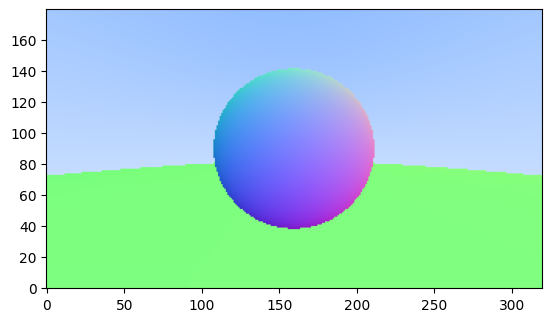

In [26]:
plt.imshow(image, origin='lower')
plt.show()